In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fmin_cg
from PIL import Image
import IPython.display as ip

## Loading .mat Files in Python

X
  - 5000 images at 20x20
  - each row 400 columns (20x20), so 1 for each pixel location
    
y
  - label for each image (0-9) 

In [667]:
matrix = scipy.io.loadmat("ex3data1.mat")

In [668]:
# view headers
matrix.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [669]:
X = matrix['X'] # 5000 x 400
y = matrix['y'] # 5000 x 1

## Visualize the data

In [670]:
# to plot single image
def display_image(pixel_row):
    array = pixel_row.reshape(20,20, order='F') # reshape to desired resolution
    img = plt.imshow(array, cmap='gray') # build in grayscale
    
    return img

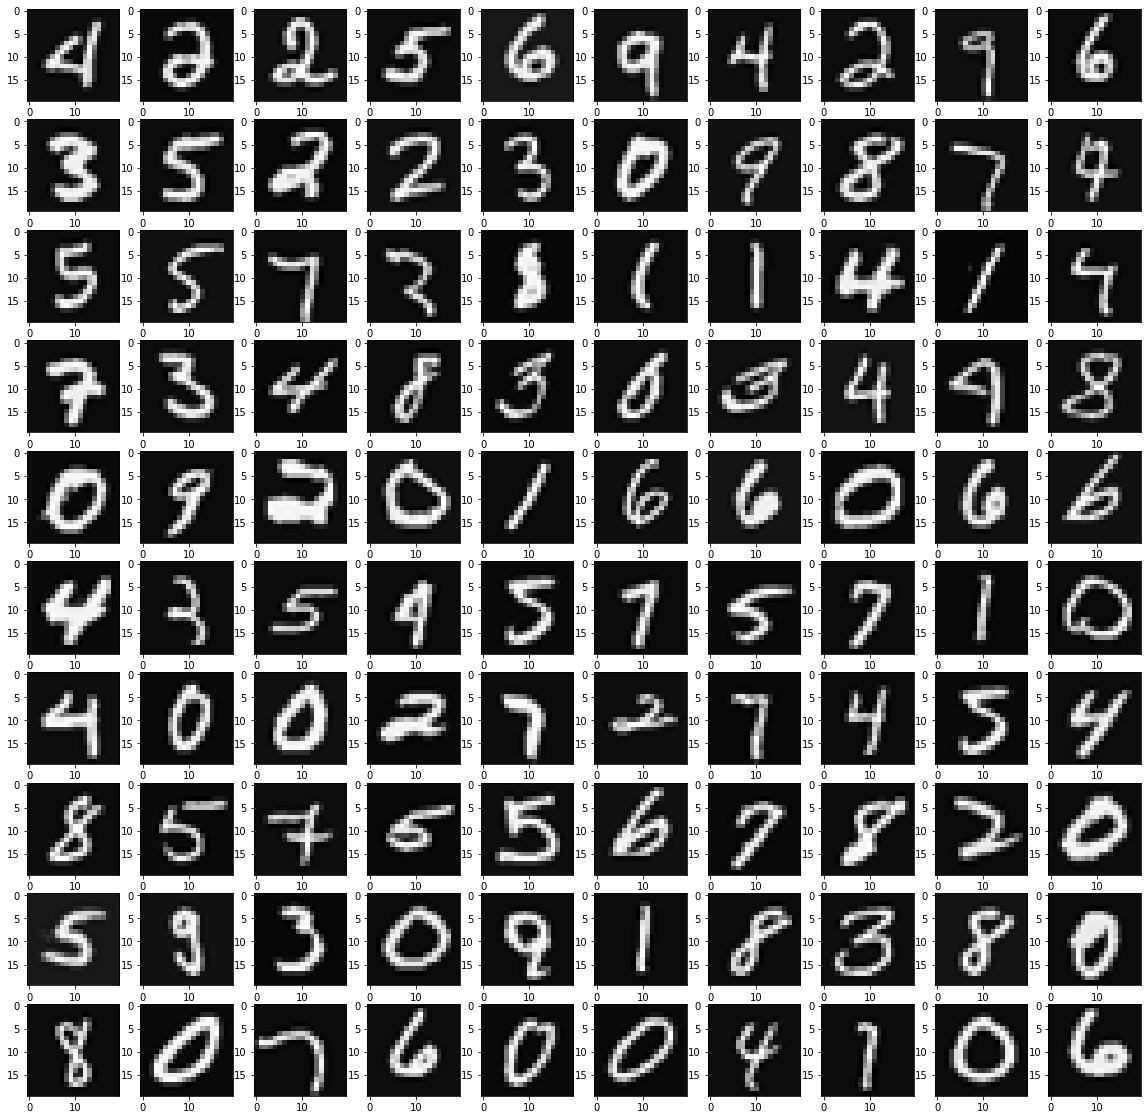

In [671]:
# build 10x10 image grid
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(20,20))
for i in range(10):
    for j in range(10):
        random_row = X[np.random.randint(0,5000), :]
        array = random_row.reshape(20,20, order='F') # reshape to desired resolution
        ax[i, j].imshow(array, cmap='gray') # plot on grid

## Vectorized Logistic Regression Approach

In [672]:
num_labels = 10
lam = 0.1

In [673]:
def sigmoid(z):
    g = 1/(1 + np.exp(-z))
    
    return g 

In [684]:
def cost_func_logReg(theta, X, y, lam):
    m = len(X)
    epsilon = 1e-5 # prevents log(0)
    J = 0

    h = sigmoid(X.dot(theta)) # 5000x401 * 401x1 = 5000x1
    first_term = -(y.T).dot(np.log(h.T + epsilon)) - (1 - y.T).dot(np.log(1-h.T + epsilon)) 
    reg_term = (lam/(2*m)) * sum(theta[1:]**2)
    J = 1/m * first_term + reg_term
    
    return J


def get_gradient(theta, X, y, lam):
    m = len(X)
    grad = np.zeros(theta.size)
    
    h = sigmoid(X.dot(theta)) 
    errors = h - y.flatten() 

    grad[0] = (1/m) * (X[:,0].T.dot(errors.T))  
    grad[1:] = (1/m) * (errors.dot(X[:,1:])) + ((lam/m) * theta[1:]) 
    
    return grad

### Test case to ensure function is working correctly

In [675]:
X_t = np.matrix([[1, 0.1, 0.6, 1.1],
                 [1, 0.2, 0.7, 1.2],
                 [1, 0.3, 0.8, 1.3],
                 [1, 0.4, 0.9, 1.4],
                 [1, 0.5, 1.0, 1.5]])
y_t = np.array([1,0,1,0,1]).T
theta_t = np.array([-2, -1, 1, 2]).T
lambda_t = 3
m_test = len(X_t)

In [676]:
J_test = cost_func_logReg(theta_t, X_t, y_t, lambda_t) # should get ~ 2.535
print(J_test)

[[2.53479503]]


In [677]:
"""
should expect [[0.147],
              [-0.549],
              [0.725],
              [1.398]]            
"""
                
grad_test = get_gradient(theta_t, X_t, y_t, lambda_t)
print(grad_test)

[ 0.14656137 -0.54855841  0.72472227  1.39800296]


## One-vs-all Classification

In [2]:
def one_vs_all(X, y, num_labels, lam):
    m = X.shape[0]
    n = X.shape[1]
    
    init_theta = np.zeros(n+1)
    
    x_ones = np.ones(m) # create ones column for x
    X = np.column_stack((x_ones, X)) # merge
    
    all_theta = np.zeros((num_labels, n+1))
    
    for i in range(num_labels):
        label = i if i else 10
        result = fmin_cg(cost_func_logReg, 
                         init_theta, 
                         fprime=get_gradient, # gradient function is needed here. Without it, it is poorly optimized
                         args=(X,(y==label),lam),
                         maxiter=50) 
        all_theta[i, :] = result.T
        
    return all_theta

In [679]:
all_theta = one_vs_all(X, y, num_labels, lam)

         Current function value: 0.009449
         Iterations: 50
         Function evaluations: 169
         Gradient evaluations: 169
         Current function value: 0.013880
         Iterations: 50
         Function evaluations: 177
         Gradient evaluations: 177
         Current function value: 0.056214
         Iterations: 50
         Function evaluations: 148
         Gradient evaluations: 148
         Current function value: 0.061314
         Iterations: 50
         Function evaluations: 148
         Gradient evaluations: 148
         Current function value: 0.039014
         Iterations: 50
         Function evaluations: 151
         Gradient evaluations: 151
         Current function value: 0.061579
         Iterations: 50
         Function evaluations: 140
         Gradient evaluations: 140
         Current function value: 0.022439
         Iterations: 50
         Function evaluations: 167
         Gradient evaluations: 167
         Current function value: 0.034746
      

In [680]:
# should have 401 weights per label (10x401)
all_theta.shape

(10, 401)

## Predict with one-vs-all

In [681]:
def predict_one_vs_all(X, y, all_theta, num_labels, m):
    preds = np.zeros(m)
    
    x_ones = np.ones(m) # create ones column for x
    X = np.column_stack((x_ones, X)) # merge

    # get 10 predictions for each sample
    results = sigmoid(X.dot(all_theta.T))  # 5000x401 * 401x10 = 5000x10
    
    # grab max value from each sample
    pred = np.argmax(results, axis=1)
    
    y = y%10 # change indexing to match python
    
    count = 0
    for i in range(len(pred)): # count number of correct matches
        if pred[i]!=y[i]:
            count+=1

    return ((m-count)/m)*100, pred
    

In [682]:
acc, preds = predict_one_vs_all(X, y, all_theta, num_labels, m)

In [685]:
# should expect around 95% accuracy 
acc

94.98